# Select Data, IRT model, and Device


In [ ]:
# 0 -> bone
# 1 (others) -> brain

#DATA = 0 
DATA = 1


In [ ]:
# 0 -> 1PL-IRT
# 1 (others) -> 2PL-IRT 

#MODEL = 0
MODEL = 1


In [ ]:
# 0 -> CPU
# 1 -> GPU
# 2 -> GPU vectorized

#DEVICE = 0
#DEVICE = 1
DEVICE = 2


In [ ]:
if DEVICE == 2:
    chain_method = 'vectorized'
else:
    chain_method = 'parallel'


# Prepare

In [ ]:
! cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
stepping	: 3
microcode	: 0xffffffff
cpu MHz		: 2000.180
cache size	: 39424 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmi

In [ ]:
#! pip install -q "jax[cuda11_cudnn805]"==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
! pip install -q numpyro==0.10.1 arviz==0.12.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.7/292.7 KB 3.9 MB/s eta 0:00:00


In [ ]:
! pip list | grep jax
! pip list | grep numpyro

jax                           0.4.4
jaxlib                        0.4.4+cuda11.cudnn82
numpyro                       0.10.1


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import numpyro
import numpyro.distributions as dist
import arviz as az
import jax
import jax.numpy as jnp

In [ ]:
if DEVICE == 0:
    numpyro.set_platform('cpu')
    numpyro.set_host_device_count(6)
else:
    numpyro.set_platform('gpu')
    n = jax.device_count()
    print("number of GPU", n)
    if n < 1:
        raise Exception("no GPU")
    else:
        ! nvidia-smi


number of GPU 1
Fri Mar  3 00:25:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    29W /  70W |    105MiB / 15360MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                        

## Import & Check Data

In [ ]:
if DATA == 0:
    ! wget https://filedn.com/lpAczQGgeBjkX6l7SpI5JJy/__ws/stan_irt_nrm_rad/bone_meta_accuracy_for_irt___2017_0608.csv -O accuracy_for_irt___2017_0608.csv
else:
    ! wget https://filedn.com/lpAczQGgeBjkX6l7SpI5JJy/__ws/stan_irt_nrm_rad/brain_stroke_accuracy_for_irt___2018_1029.csv -O accuracy_for_irt___2017_0608.csv

df_ = pd.read_csv('./accuracy_for_irt___2017_0608.csv')

if DATA == 0:
    df = df_.iloc[0:60,2:9]
else:
    df = df_.iloc[0:42,2:16]

--2023-03-03 00:25:56--  https://filedn.com/lpAczQGgeBjkX6l7SpI5JJy/__ws/stan_irt_nrm_rad/brain_stroke_accuracy_for_irt___2018_1029.csv
Resolving filedn.com (filedn.com)... 74.120.9.25
Connecting to filedn.com (filedn.com)|74.120.9.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3700 (3.6K) [text/csv]
Saving to: ‘accuracy_for_irt___2017_0608.csv’

accuracy_for_irt___ 100%[===================>]   3.61K  --.-KB/s    in 0s      

2023-03-03 00:25:57 (701 MB/s) - ‘accuracy_for_irt___2017_0608.csv’ saved [3700/3700]



In [ ]:
df.head()

,Dr.A,Dr.B,Dr.C,Dr.D,Dr.E,Dr.F,Dr.G,Dr.H,Dr.I,Dr.J,Dr.K,Dr.L,Dr.M,Dr.N
0,1,1,1,1,1,1,1,1,1,0,1,1,0,1
1,1,1,1,1,1,1,1,0,1,1,0,1,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [ ]:
df.describe()

,Dr.A,Dr.B,Dr.C,Dr.D,Dr.E,Dr.F,Dr.G,Dr.H,Dr.I,Dr.J,Dr.K,Dr.L,Dr.M,Dr.N
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,0.761905,0.690476,0.761905,0.690476,0.714286,0.714286,0.476190,0.380952,0.761905,0.666667,0.761905,0.761905,0.595238,0.619048
std,0.431081,0.467901,0.431081,0.467901,0.457230,0.457230,0.505487,0.491507,0.431081,0.477119,0.431081,0.431081,0.496796,0.491507
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
if DATA == 0:
    print(0, (df["Dr1."]==0).sum())
    print(1, (df["Dr1."]==1).sum())
else:
    print(0, (df["Dr.A"]==0).sum())
    print(1, (df["Dr.A"]==1).sum())


# 0 -> inaccurate diagnosis 
# 1 -> accurate diagnosis


0 10
1 32


## Convert DataFrame

In [ ]:
rad_resp = df.copy()

In [ ]:
num_case = rad_resp.shape[0]
num_rad = rad_resp.shape[1]


In [ ]:
print(num_case)
print(num_rad)

42
14


In [ ]:
rad_resp

,Dr.A,Dr.B,Dr.C,Dr.D,Dr.E,Dr.F,Dr.G,Dr.H,Dr.I,Dr.J,Dr.K,Dr.L,Dr.M,Dr.N
0,1,1,1,1,1,1,1,1,1,0,1,1,0,1
1,1,1,1,1,1,1,1,0,1,1,0,1,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,0,0,0,0,1,0,0,0,0,0,0,0,1
7,1,0,1,1,1,1,1,1,1,0,0,1,1,1
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,1,1,1,1,1,0,1,1,1,1,1,1


In [ ]:
y = rad_resp.to_numpy()

# Run Numpyro

## Define Model

In [ ]:
def model_1pl(y=None, num_cases=0, num_doctors=0):
    with numpyro.plate('doctor', num_doctors):
      theta = numpyro.sample('theta', dist.Normal(0, 2))

    with numpyro.plate('case', num_cases, dim=-2):
        beta = numpyro.sample('beta', dist.Normal(0, 2))
        with numpyro.plate('doctor', num_doctors):
            mu = theta - beta
            numpyro.sample('obs', dist.Bernoulli(logits=mu), obs=y)

In [ ]:
def model_2pl(y=None, num_cases=0, num_doctors=0):
    with numpyro.plate('doctor', num_doctors):
      theta = numpyro.sample('theta', dist.Normal(0, 2))

    with numpyro.plate('case', num_cases, dim=-2):
        beta = numpyro.sample('beta', dist.Normal(0, 2))
        log_d = numpyro.sample('log_d', dist.Normal(0.5, 1))
        with numpyro.plate('doctor', num_doctors):
            mu = jnp.exp(log_d)*(theta - beta)
            numpyro.sample('obs', dist.Bernoulli(logits=mu), obs=y)

In [ ]:
model = model_1pl if MODEL == 0 else model_2pl

In [ ]:
nuts = numpyro.infer.NUTS(model)

In [ ]:
print(chain_method)

vectorized


In [ ]:
mcmc = numpyro.infer.MCMC(nuts, num_warmup=2000, num_samples=8000, num_chains=6, chain_method=chain_method)
#mcmc = numpyro.infer.MCMC(nuts, num_warmup=2000, num_samples=8000, chain_method=chain_method)

mcmc.run(jax.random.PRNGKey(0), y=y, num_cases=num_case, num_doctors=num_rad)
mcmc_samples = mcmc.get_samples()

sample: 100%|██████████| 10000/10000 [02:40<00:00, 62.30it/s]


## Check Results

In [ ]:
idata = az.from_numpyro(mcmc)
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

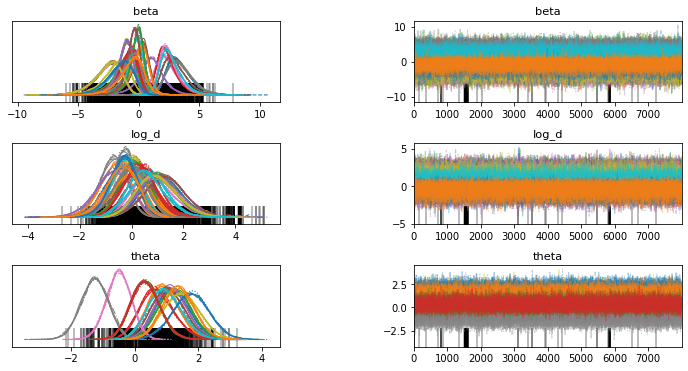

In [ ]:
axes = az.plot_trace(idata)
plt.gcf().subplots_adjust(wspace=0.5, hspace=0.5)

In [ ]:
az.summary(idata, var_names=['theta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta[0],1.186,0.527,0.226,2.197,0.004,0.003,17302.0,20916.0,1.0
theta[1],0.897,0.488,0.001,1.827,0.004,0.003,16923.0,26620.0,1.0
theta[2],1.251,0.517,0.292,2.220,0.004,0.003,15879.0,16665.0,1.0
theta[3],0.702,0.532,-0.303,1.695,0.004,0.003,16956.0,26275.0,1.0
theta[4],1.133,0.500,0.204,2.080,0.004,0.003,18464.0,28238.0,1.0
theta[5],1.040,0.515,0.081,2.007,0.004,0.003,16628.0,28830.0,1.0
theta[6],-0.507,0.392,-1.248,0.228,0.003,0.002,13277.0,24086.0,1.0
theta[7],-1.264,0.433,-2.076,-0.458,0.004,0.003,14157.0,19916.0,1.0
theta[8],1.455,0.565,0.395,2.504,0.004,0.003,17398.0,23571.0,1.0
theta[9],0.942,0.528,-0.051,1.925,0.004,0.003,17510.0,22661.0,1.0


In [ ]:
az.summary(idata, var_names=['beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[0, 0]",-1.574,1.120,-3.793,0.298,0.006,0.005,34113.0,29428.0,1.0
"beta[1, 0]",-0.976,1.035,-3.031,0.748,0.006,0.005,30992.0,26996.0,1.0
"beta[2, 0]",3.375,1.023,1.662,5.333,0.006,0.005,26356.0,27989.0,1.0
"beta[3, 0]",-2.603,1.137,-4.854,-0.707,0.006,0.005,37438.0,27987.0,1.0
"beta[4, 0]",-2.609,1.146,-4.840,-0.680,0.007,0.005,23866.0,10108.0,1.0
"beta[5, 0]",-2.604,1.134,-4.796,-0.691,0.006,0.005,36965.0,27864.0,1.0
"beta[6, 0]",2.248,0.990,0.546,4.245,0.006,0.004,26538.0,26810.0,1.0
"beta[7, 0]",-1.395,1.241,-3.808,0.794,0.007,0.006,29541.0,22792.0,1.0
"beta[8, 0]",3.366,1.021,1.665,5.332,0.007,0.005,20288.0,7933.0,1.0
"beta[9, 0]",-1.210,0.782,-2.703,0.130,0.006,0.004,21284.0,21301.0,1.0


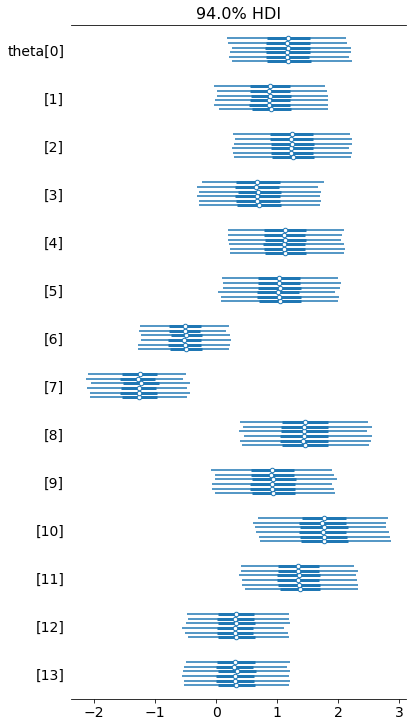

In [ ]:
axes = az.plot_forest(idata, var_names=['theta'])